<a href="https://colab.research.google.com/github/DuskyT-byte/code/blob/main/Loan_default.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Project Title

##### AI-Powered Loan Default Predictor

### Objective

To create an AI-driven system that predicts loan default risk using borrower profiles and financial behavior data. This system enables fintechs and
microfinance institutions to make informed lending decisions based on data.

#### Problem Statement

Loan default is a significant risk in digital lending, particularly in emerging markets such as Nigeria, where credit histories are often limited and incomplete.
A predictive system that utilises behavioural and transactional data can enhance risk assessment beyond the capabilities of traditional credit scoring methods.

#### Goal: Predict loan default using ML models

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, RocCurveDisplay
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier



# All columns will be shown
pd.set_option('display.max_columns', None)

In [ ]:
# Load dataset
df = pd.read_csv("nigerian_loan_default.csv")

print("Dataset shape:", df.shape)
display(df.head())

Dataset shape: (100000, 67)


,loan_amnt,term,int_rate,annual_inc,emp_length,home_ownership,verification_status,purpose,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,grade,installment,loan_status,debt_to_income_ratio,loan_to_monthly_income,high_dti_flag,stable_employment,very_stable_employment,inquiry_pressure,account_diversity,high_utilization,very_high_utilization,large_loan_flag,long_term_loan,grade_numeric,high_risk_grade,purpose_risk_score,high_risk_purpose,verification_strength,strong_verification,estimated_age,income_tier,state,is_urban,uses_airtime,airtime_frequency,airtime_avg_amount,airtime_monthly_spend,uses_betting,betting_frequency,betting_avg_amount,betting_monthly_spend,uses_savings,savings_frequency,savings_avg_amount,savings_monthly_spend,uses_shortterm_loans,shortterm_loans_frequency,shortterm_loans_avg_amount,shortterm_loans_monthly_spend,uses_entertainment,entertainment_frequency,entertainment_avg_amount,entertainment_monthly_spend,uses_utilities,utilities_frequency,utilities_avg_amount,utilities_monthly_spend,financial_discipline_score,total_monthly_spend,risk_seeking_score
0,2000000.0,60.0,10.49,10000000.0,10.0,OWN,Verified,debt_consolidation,24.05,0.0,0.0,20.0,0.0,39687.0,57.8,42.0,B,103147.5,0,0.266664,3.199680,0,1,1,0.000000,0.465116,0,0,1,0,2.0,0,3.0,0,3.0,1,35,Premium,Abuja,0,1,50.0,1656.35,82817.39,0,0.0,0.0,0.0,0,0.0,0.00,0.00,0,0.0,0.00,0.00,0,0.0,0.00,0.00,1,6.0,35242.63,211455.79,3,294273.18,0
1,1440000.0,36.0,12.99,3285000.0,0.0,RENT,Verified,debt_consolidation,10.03,0.0,1.0,13.0,1.0,4509.0,38.9,20.0,C,48513.0,0,0.438336,5.257393,0,0,0,0.071429,0.619048,0,0,0,0,3.0,0,3.0,0,3.0,1,30,High,Others,1,1,6.0,1010.03,6060.17,0,0.0,0.0,0.0,0,0.0,0.00,0.00,0,0.0,0.00,0.00,1,3.0,2563.83,7691.49,0,0.0,0.00,0.00,3,13751.66,0
2,600000.0,36.0,6.68,10000000.0,4.0,OWN,Not Verified,major_purchase,19.53,0.0,0.0,16.0,0.0,1564.0,17.2,25.0,A,18439.5,0,0.048192,0.578230,0,1,0,0.000000,0.615385,0,0,0,0,1.0,0,2.0,0,1.0,0,37,Premium,Lagos,1,1,36.0,2747.07,98894.35,0,0.0,0.0,0.0,1,2.0,68921.39,137842.78,1,2.0,47666.93,95333.85,1,4.0,8225.66,32902.62,0,0.0,0.00,0.00,4,364973.61,2
3,903750.0,36.0,10.91,7800000.0,10.0,RENT,Not Verified,debt_consolidation,9.16,1.0,1.0,11.0,0.0,2706.0,12.8,25.0,B,29550.0,0,0.115863,1.390064,0,1,1,0.083333,0.423077,0,0,0,0,2.0,0,3.0,0,1.0,0,44,High,Others,0,1,17.0,799.45,13590.61,0,0.0,0.0,0.0,0,0.0,0.00,0.00,0,0.0,0.00,0.00,1,6.0,3232.77,19396.62,1,2.0,12988.53,25977.06,3,58964.29,0
4,2000000.0,60.0,26.30,9750000.0,10.0,OWN,Verified,debt_consolidation,36.26,0.0,1.0,19.0,0.0,49461.0,24.7,33.0,E,112944.0,0,0.384609,4.614533,1,1,1,0.050000,0.558824,0,0,1,0,5.0,1,3.0,0,3.0,1,30,Premium,Lagos,1,1,50.0,2804.34,140217.07,0,0.0,0.0,0.0,0,0.0,0.00,0.00,0,0.0,0.00,0.00,0,0.0,0.00,0.00,0,0.0,0.00,0.00,3,140217.07,0


In [ ]:
# Explore data
print("\n Missing values per column:")
display(df.isnull().sum().to_frame("Missing Values"))


 Missing values per column:


,Missing Values
loan_amnt,4
term,4
int_rate,4
annual_inc,4
emp_length,0
...,...
utilities_avg_amount,0
utilities_monthly_spend,0
financial_discipline_score,0
total_monthly_spend,0


/tmp/ipython-input-3272172803.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="loan_status", data=df, palette="pastel")


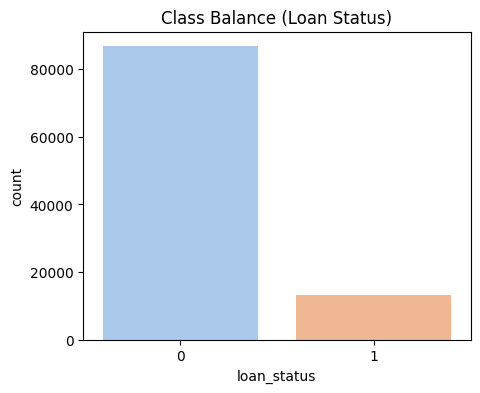

In [ ]:
# Class balance
plt.figure(figsize=(5,4))
sns.countplot(x="loan_status", data=df, palette="pastel")
plt.title("Class Balance (Loan Status)")
plt.show()

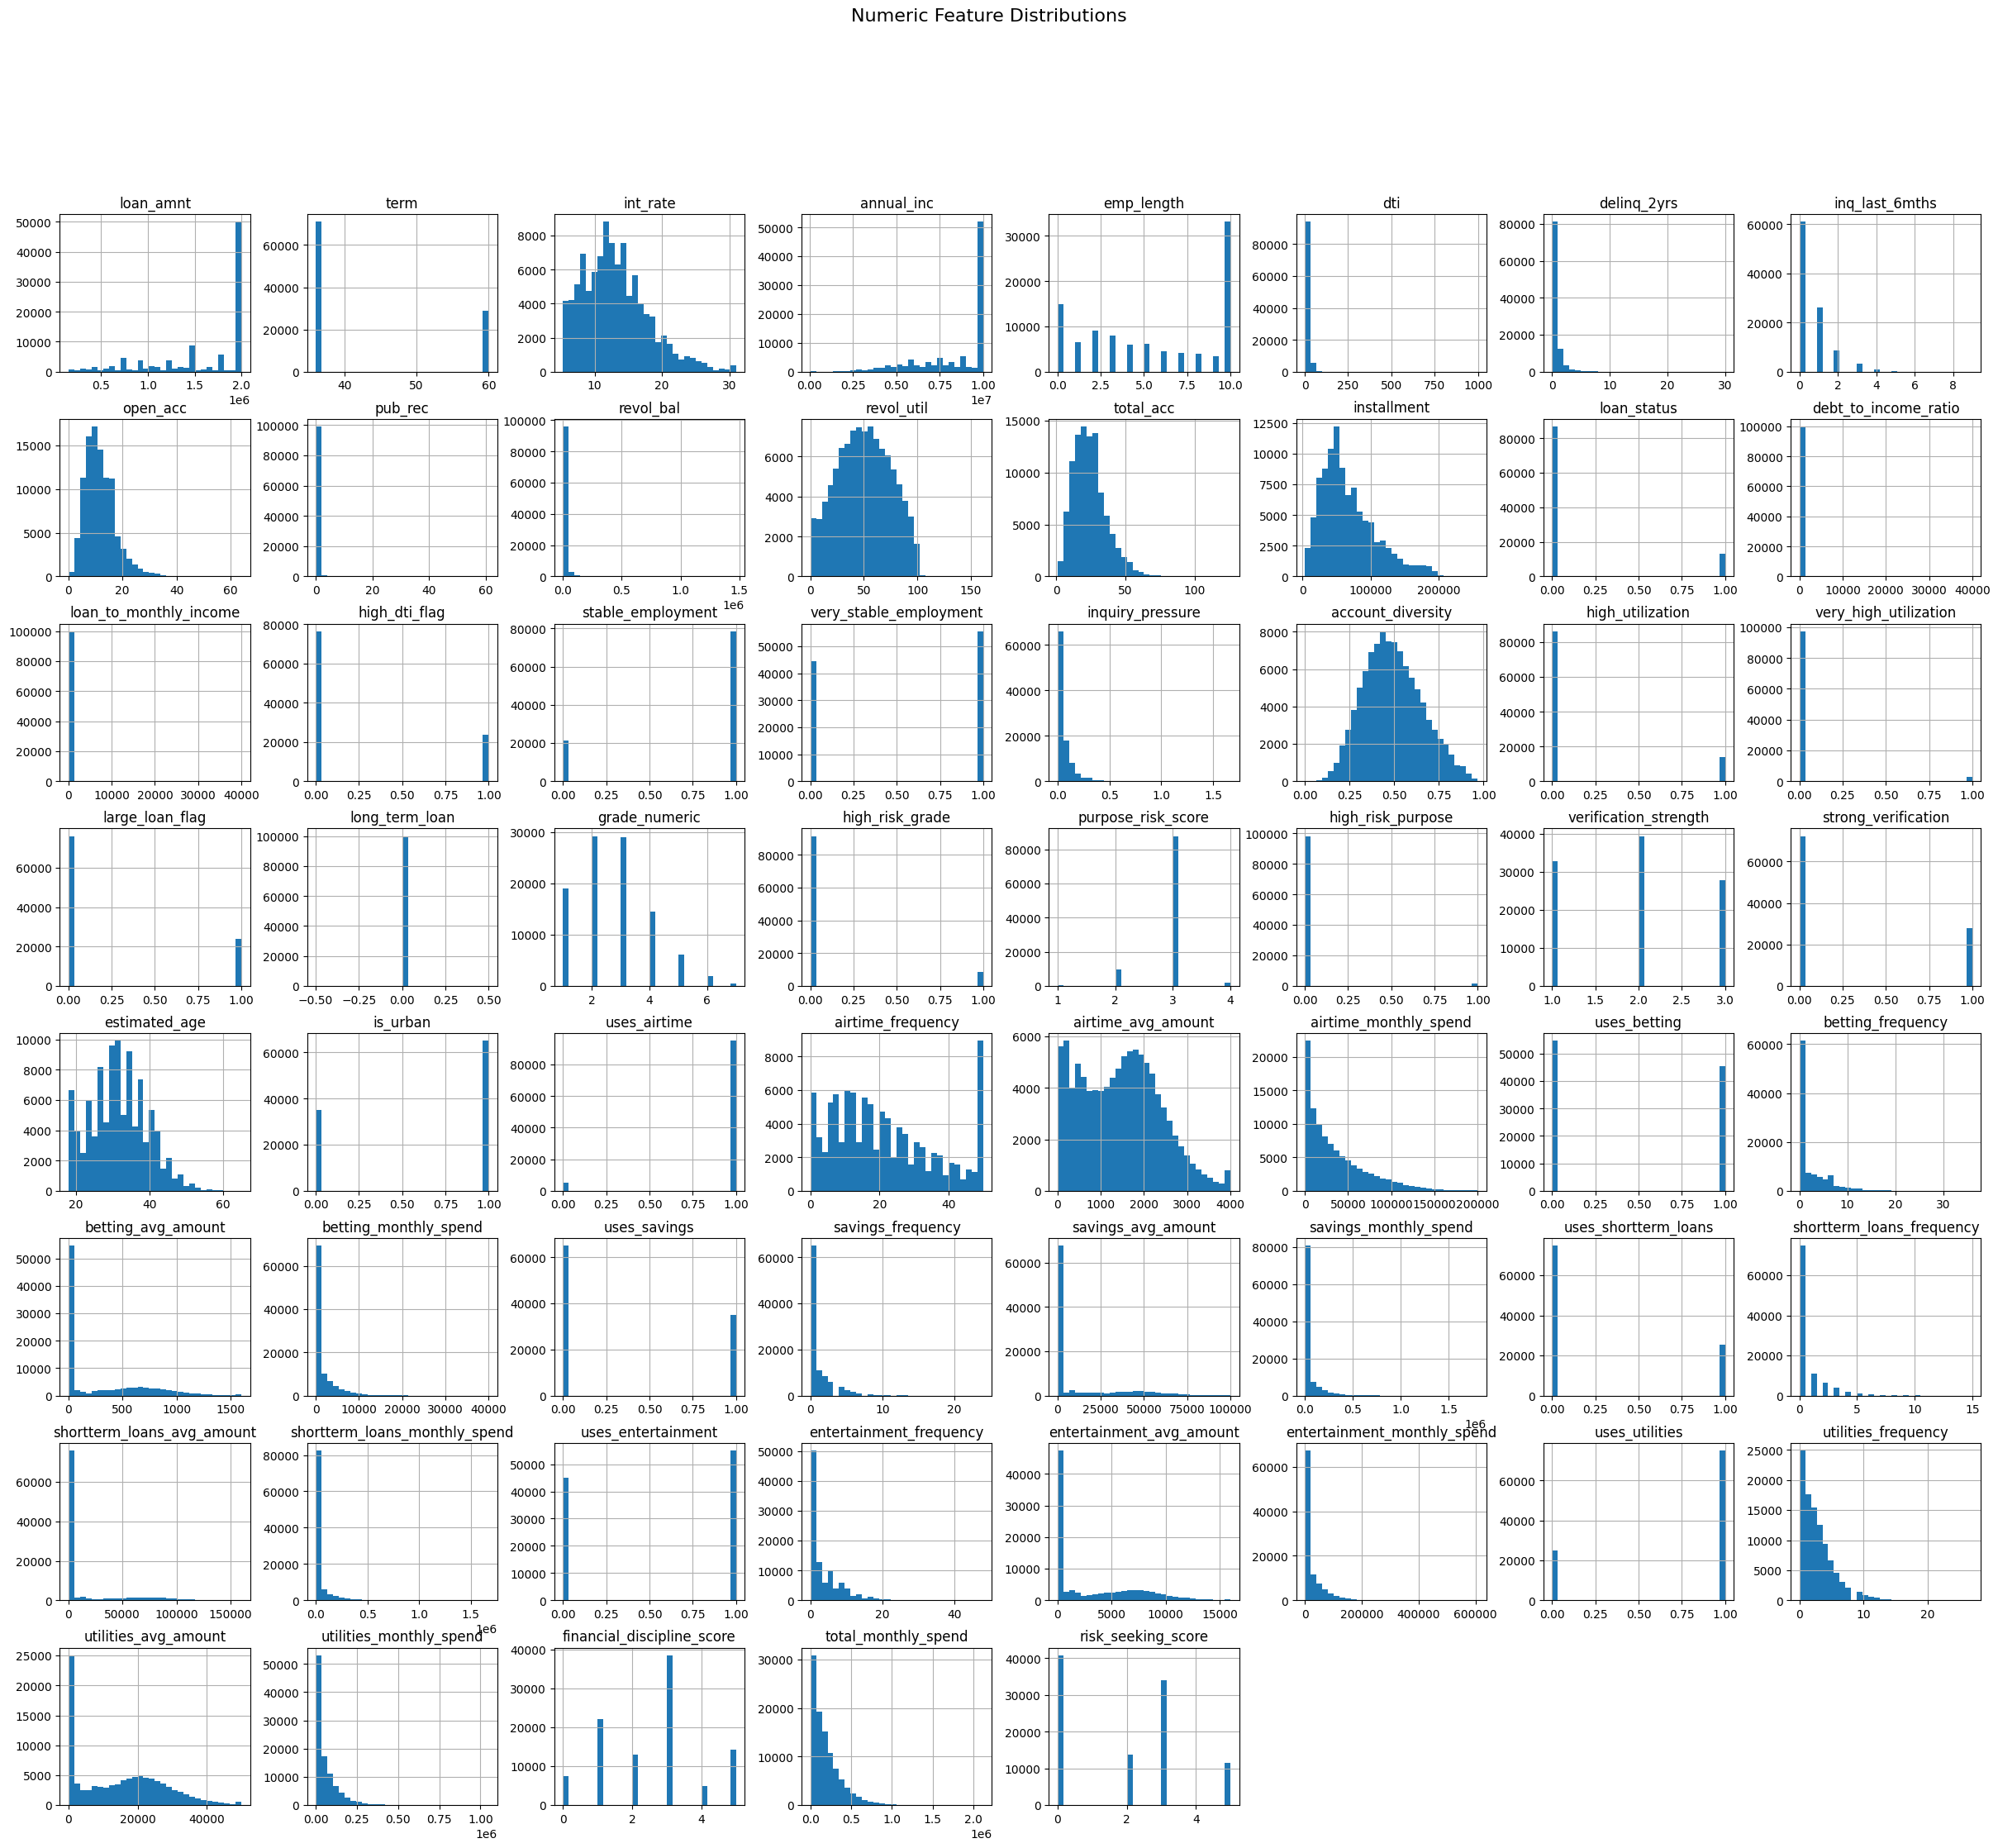

In [ ]:
# Numeric distribution (first few numeric columns only)
num_cols = df.select_dtypes(include=np.number).columns.tolist()
df[num_cols].hist(bins=30, figsize=(30,25))
plt.suptitle("Numeric Feature Distributions", fontsize=16)
plt.show()

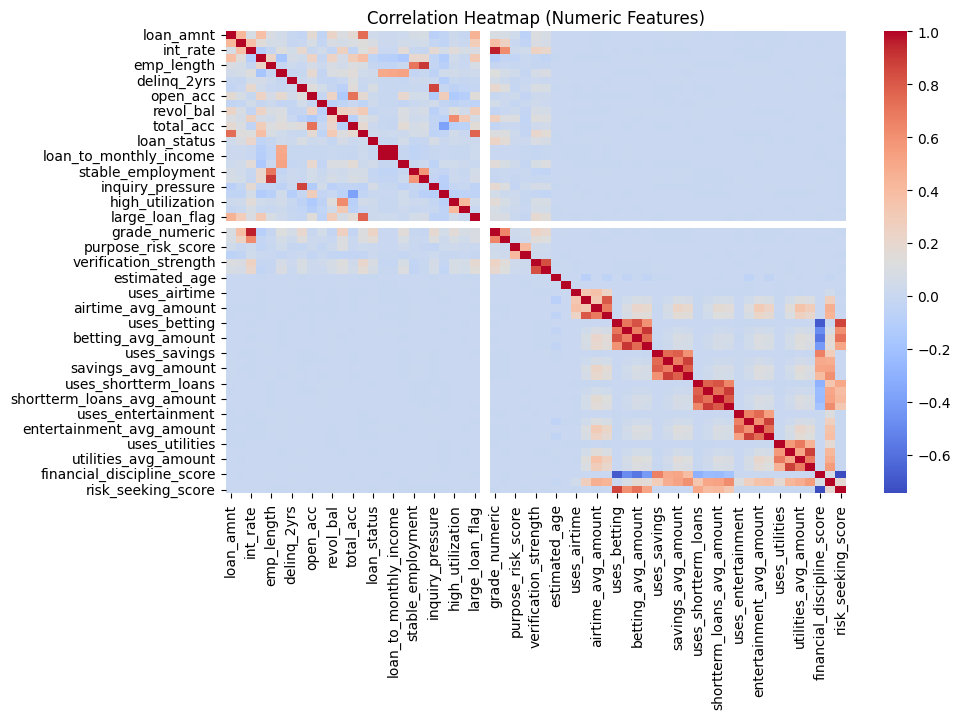

In [ ]:
# Correlation heatmap
plt.figure(figsize=(10,6))
sns.heatmap(df[num_cols].corr(), cmap="coolwarm", annot=False)
plt.title("Correlation Heatmap (Numeric Features)")
plt.show()

In [ ]:
# Preprocessing
X = df.drop("loan_status", axis=1)
y = df["loan_status"]

num_features = X.select_dtypes(include=np.number).columns
cat_features = X.select_dtypes(exclude=np.number).columns

num_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_transformer, num_features),
        ("cat", cat_transformer, cat_features)
    ]
)


In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
# Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=200, solver="liblinear"),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
}

results = []


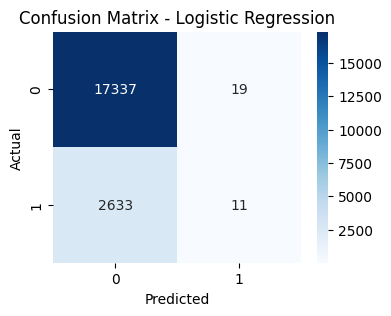

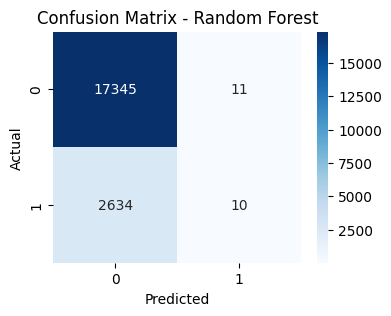

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [22:35:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


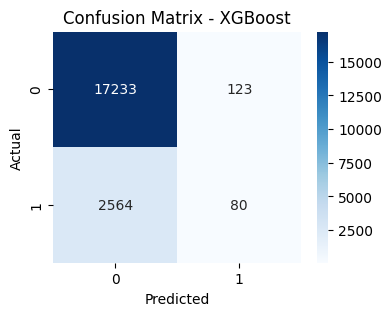

In [ ]:
# Train & evaluate

for name, model in models.items():
    clf = Pipeline(steps=[("preprocessor", preprocessor),
                          ("classifier", model)])
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test)[:,1]

    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "ROC-AUC": roc_auc_score(y_test, y_proba)
    })

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


In [ ]:
# Results summary
results_df = pd.DataFrame(results).set_index("Model")
display(results_df.style.background_gradient(cmap="Blues").format("{:.3f}"))


,Accuracy,Precision,Recall,F1,ROC-AUC
Model,,,,,
Logistic Regression,0.867,0.367,0.004,0.008,0.701
Random Forest,0.868,0.476,0.004,0.008,0.685
XGBoost,0.866,0.394,0.030,0.056,0.694


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [22:37:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


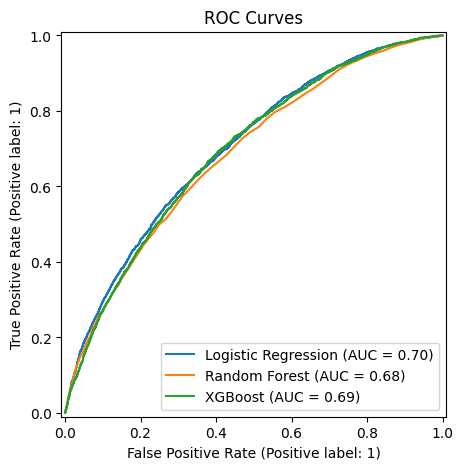

In [ ]:
# ROC Curves

plt.figure(figsize=(7,5))
for name, model in models.items():
    clf = Pipeline(steps=[("preprocessor", preprocessor),
                          ("classifier", model)])
    clf.fit(X_train, y_train)
    RocCurveDisplay.from_estimator(clf, X_test, y_test, name=name, ax=plt.gca())
plt.title("ROC Curves")
plt.show()

# Project Report

## Executive Summary
This project explored machine learning methods to predict loan default risk.  
EDA revealed missing values, class imbalance, and correlations between income, loan amount, and default status.  
We applied three models: Logistic Regression, Random Forest, and XGBoost.

## Findings
- **Logistic Regression**: Fast, interpretable, but moderate accuracy.  
- **Random Forest**: Better performance, robust to feature noise.  
- **XGBoost**: Best overall performance (highest ROC-AUC, balanced precision/recall).  

## Recommendations
- Use **XGBoost** for production deployment.  
- Improve dataset with more borrower history features.  
- Perform hyperparameter tuning for further gains.  
- Integrate into a credit risk scoring system.  

## Limitations
- Dataset may not represent all borrower populations.  
- Potential bias if socioeconomic data is incomplete.  

